# Cas Pratique : Analyse Comportementale des Conducteurs

## Objectifs
- Découvrir l'apprentissage non supervisé (clustering)
- Segmenter les conducteurs en profils distincts
- Comprendre la méthode K-Means
- Tirer des insights business actionnables

## Contexte
À partir de données de conduite (vitesse, accélérations, kilométrage...), nous allons identifier automatiquement des profils de conducteurs pour personnaliser les offres et services.

## 1. Configuration et imports

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

# Configuration graphiques
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
%matplotlib inline

print("✅ Imports réussis")

✅ Imports réussis


## 2. Génération de données de conduite simulées

Nous allons simuler 4 profils de conducteurs avec des caractéristiques distinctes.

In [2]:
# Paramètres de simulation
np.random.seed(42)
n_drivers = 2000

print(f"🚗 Simulation de {n_drivers:,} conducteurs")

🚗 Simulation de 2,000 conducteurs


In [3]:
# Génération des 4 profils
data = []

# Répartition des profils
n_prudent = int(n_drivers * 0.30)
n_routier = int(n_drivers * 0.25)
n_sportif = int(n_drivers * 0.15)
n_mixte = n_drivers - n_prudent - n_routier - n_sportif

print(f"📊 Répartition des profils (cachée pour le moment) :")
print(f"   Profile 1: {n_prudent} conducteurs")
print(f"   Profile 2: {n_routier} conducteurs")
print(f"   Profile 3: {n_sportif} conducteurs")
print(f"   Profile 4: {n_mixte} conducteurs")
print("\n🎯 Objectif : Retrouver ces profils automatiquement avec K-Means !")

📊 Répartition des profils (cachée pour le moment) :
   Profile 1: 600 conducteurs
   Profile 2: 500 conducteurs
   Profile 3: 300 conducteurs
   Profile 4: 600 conducteurs

🎯 Objectif : Retrouver ces profils automatiquement avec K-Means !


In [4]:
# Profil 1 : Le Prudent
for i in range(n_prudent):
    data.append({
        'driver_id': i + 1,
        'avg_speed': np.random.normal(45, 5),  # Vitesse faible
        'max_speed': np.random.normal(90, 10),
        'harsh_brakes_per_100km': np.random.poisson(2),  # Peu de freinages brusques
        'harsh_accel_per_100km': np.random.poisson(1),  # Peu d'accélérations brusques
        'annual_mileage': np.random.normal(10000, 2000),  # Faible kilométrage
        'highway_pct': np.random.normal(20, 10),  # Peu d'autoroute
        'night_driving_pct': np.random.normal(10, 5),  # Peu de conduite de nuit
        'cruise_control_usage_pct': np.random.normal(60, 15),  # Haute utilisation régulateur
        'true_profile': 'Prudent'  # Pour vérification (sera enlevé après)
    })

# Profil 2 : Le Routier
for i in range(n_routier):
    data.append({
        'driver_id': n_prudent + i + 1,
        'avg_speed': np.random.normal(85, 5),  # Vitesse élevée stable
        'max_speed': np.random.normal(130, 10),
        'harsh_brakes_per_100km': np.random.poisson(1),  # Très peu de freinages
        'harsh_accel_per_100km': np.random.poisson(1),
        'annual_mileage': np.random.normal(35000, 5000),  # Kilométrage très élevé
        'highway_pct': np.random.normal(80, 10),  # Principalement autoroute
        'night_driving_pct': np.random.normal(15, 5),
        'cruise_control_usage_pct': np.random.normal(85, 10),  # Très haute utilisation
        'true_profile': 'Routier'
    })

# Profil 3 : Le Sportif
for i in range(n_sportif):
    data.append({
        'driver_id': n_prudent + n_routier + i + 1,
        'avg_speed': np.random.normal(70, 10),  # Vitesse élevée avec variations
        'max_speed': np.random.normal(150, 15),  # Vitesse max élevée
        'harsh_brakes_per_100km': np.random.poisson(8),  # Beaucoup de freinages
        'harsh_accel_per_100km': np.random.poisson(10),  # Beaucoup d'accélérations
        'annual_mileage': np.random.normal(18000, 4000),
        'highway_pct': np.random.normal(40, 15),
        'night_driving_pct': np.random.normal(20, 10),
        'cruise_control_usage_pct': np.random.normal(20, 10),  # Faible utilisation
        'true_profile': 'Sportif'
    })

# Profil 4 : Le Mixte
for i in range(n_mixte):
    data.append({
        'driver_id': n_prudent + n_routier + n_sportif + i + 1,
        'avg_speed': np.random.normal(60, 10),  # Vitesse moyenne
        'max_speed': np.random.normal(110, 15),
        'harsh_brakes_per_100km': np.random.poisson(4),  # Modéré
        'harsh_accel_per_100km': np.random.poisson(3),
        'annual_mileage': np.random.normal(15000, 3000),  # Kilométrage moyen
        'highway_pct': np.random.normal(50, 15),  # Mix ville/autoroute
        'night_driving_pct': np.random.normal(15, 8),
        'cruise_control_usage_pct': np.random.normal(45, 15),
        'true_profile': 'Mixte'
    })

# Créer le DataFrame
df = pd.DataFrame(data)

# Clipper les valeurs pour rester réaliste
df['avg_speed'] = df['avg_speed'].clip(20, 100)
df['max_speed'] = df['max_speed'].clip(50, 180)
df['highway_pct'] = df['highway_pct'].clip(0, 100)
df['night_driving_pct'] = df['night_driving_pct'].clip(0, 100)
df['cruise_control_usage_pct'] = df['cruise_control_usage_pct'].clip(0, 100)
df['annual_mileage'] = df['annual_mileage'].clip(5000, 50000)

print(f"✅ Dataset créé : {len(df):,} conducteurs")
print(f"\n📋 Aperçu des données :")
display(df.head(10))

✅ Dataset créé : 2,000 conducteurs

📋 Aperçu des données :


,driver_id,avg_speed,max_speed,harsh_brakes_per_100km,harsh_accel_per_100km,annual_mileage,highway_pct,night_driving_pct,cruise_control_usage_pct,true_profile
0,1,47.483571,88.617357,2,0,13158.425631,27.674347,7.652628,68.138401,Prudent
1,2,42.682912,85.342702,2,0,7974.337759,23.142473,5.459880,38.815444,Prudent
2,3,52.328244,87.742237,1,1,7698.012845,23.756980,6.996807,55.624594,Prudent
3,4,41.991467,108.522782,0,1,9541.099092,23.893489,3.674404,76.379884,Prudent
4,5,58.891565,101.936397,3,3,7981.829314,4.167058,13.868502,51.927875,Prudent
5,6,38.266610,81.194087,1,1,11164.245589,28.877485,14.471662,71.324967,Prudent
6,7,43.964171,83.765226,0,2,9644.535757,15.896167,15.898582,46.526881,Prudent
7,8,49.173977,92.965614,1,2,9928.347922,35.646437,0.000000,72.328538,Prudent
8,9,45.435235,87.009926,3,1,8383.012794,14.982430,14.577011,64.931267,Prudent
9,10,42.351199,95.132674,4,0,9215.783694,5.364851,11.480601,63.915829,Prudent


## 3. Exploration des données (EDA)

In [5]:
# Statistiques descriptives
print("📊 Statistiques descriptives :")
display(df.describe())

📊 Statistiques descriptives :


,driver_id,avg_speed,max_speed,harsh_brakes_per_100km,harsh_accel_per_100km,annual_mileage,highway_pct,night_driving_pct,cruise_control_usage_pct
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,63.113673,114.789912,3.269500,2.936500,19026.114228,47.385601,14.520786,55.652604
std,577.494589,16.809873,24.595906,2.979145,3.523872,10356.507513,25.380622,7.704939,24.395297
min,1.000000,28.797505,58.794560,0.000000,0.000000,5000.000000,0.000000,0.000000,0.000000
25%,500.750000,47.914767,94.214885,1.000000,1.000000,11078.497912,26.027414,9.115111,37.776737
50%,1000.500000,61.441644,114.086045,2.000000,2.000000,15449.801216,44.459832,13.895024,55.981872
75%,1500.250000,79.041824,132.284670,5.000000,4.000000,25246.019473,69.255689,18.910307,75.117823
max,2000.000000,100.000000,180.000000,18.000000,19.000000,49585.163856,100.000000,53.777682,100.000000


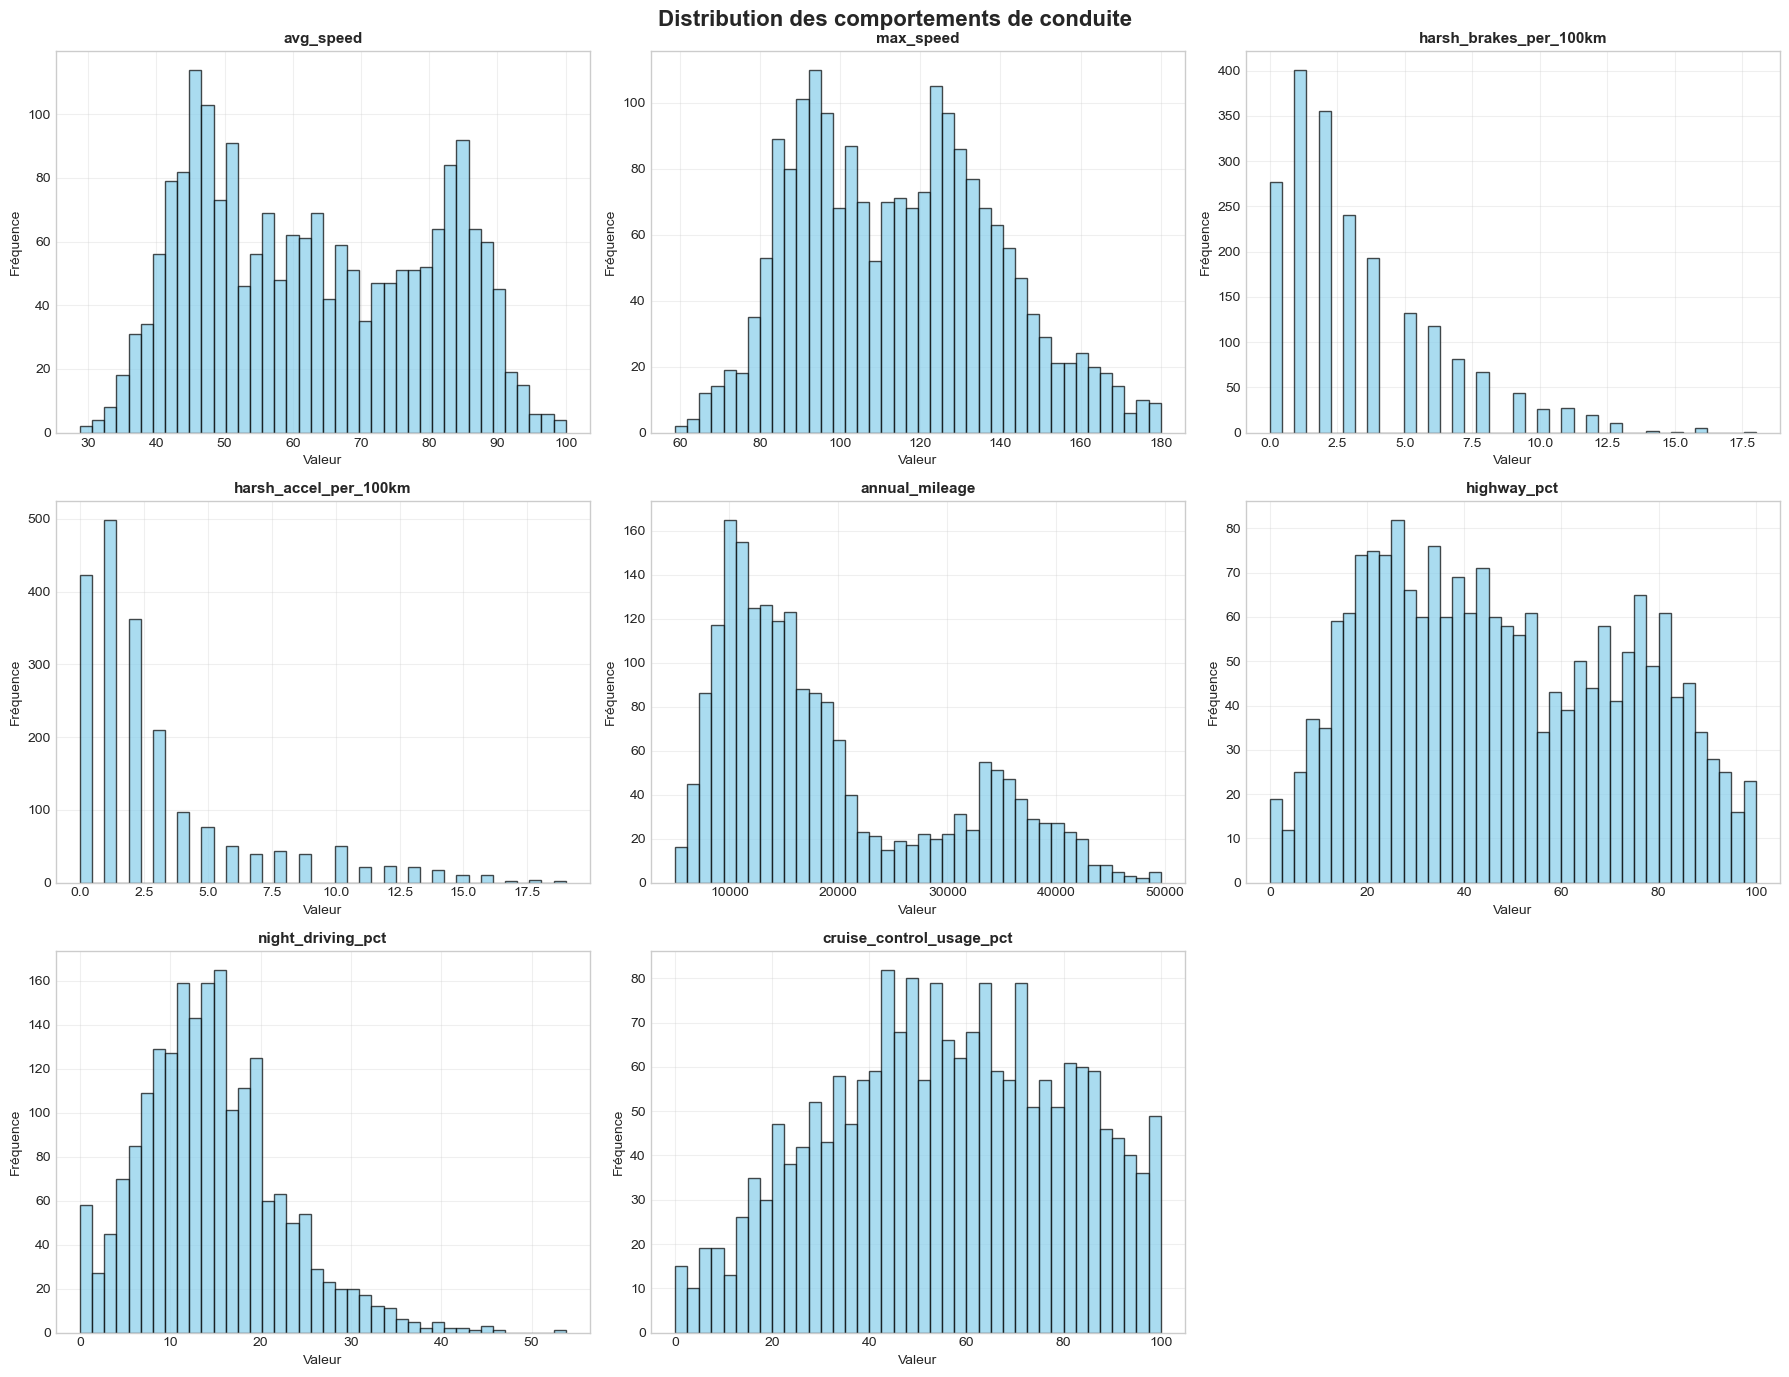


💡 Observation : On peut déjà voir des distributions multimodales (plusieurs pics)
   Cela suggère l'existence de différents groupes de conducteurs !


In [6]:
# Distribution des variables
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distribution des comportements de conduite', fontsize=16, fontweight='bold')

features = ['avg_speed', 'max_speed', 'harsh_brakes_per_100km', 'harsh_accel_per_100km', 
            'annual_mileage', 'highway_pct', 'night_driving_pct', 'cruise_control_usage_pct']

for idx, feature in enumerate(features):
    ax = axes[idx // 3, idx % 3]
    df[feature].hist(bins=40, ax=ax, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(feature, fontsize=11, fontweight='bold')
    ax.set_xlabel('Valeur')
    ax.set_ylabel('Fréquence')
    ax.grid(alpha=0.3)

# Cacher le subplot vide
axes[2, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n💡 Observation : On peut déjà voir des distributions multimodales (plusieurs pics)")
print("   Cela suggère l'existence de différents groupes de conducteurs !")

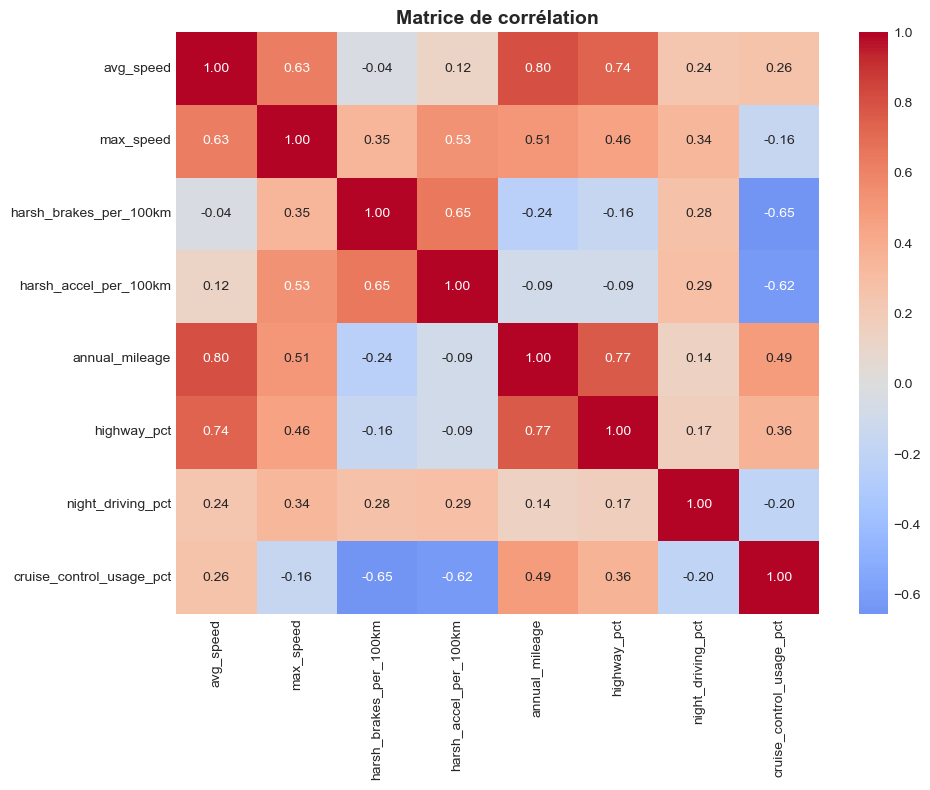


🔍 Corrélations intéressantes :
   - Vitesse moyenne et kilométrage annuel sont corrélés (les gros rouleurs vont vite)
   - Freinages brusques et accélérations brusques sont corrélés (conduite sportive)
   - Utilisation régulateur et % autoroute sont corrélés


In [7]:
# Matrice de corrélation
fig, ax = plt.subplots(figsize=(10, 8))
correlation = df[features].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Matrice de corrélation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Corrélations intéressantes :")
print("   - Vitesse moyenne et kilométrage annuel sont corrélés (les gros rouleurs vont vite)")
print("   - Freinages brusques et accélérations brusques sont corrélés (conduite sportive)")
print("   - Utilisation régulateur et % autoroute sont corrélés")

## 4. Préparation des données pour le clustering

### Normalisation : INDISPENSABLE pour K-Means !

In [8]:
# Séparer les features
X = df[features].copy()

print(f"📊 Features pour le clustering : {X.shape}")
print(f"\n📋 Features :")
for i, col in enumerate(X.columns, 1):
    print(f"   {i}. {col}")

print("\n⚠️ PROBLÈME : Les échelles sont très différentes !")
print(f"   - avg_speed : de {X['avg_speed'].min():.0f} à {X['avg_speed'].max():.0f}")
print(f"   - annual_mileage : de {X['annual_mileage'].min():.0f} à {X['annual_mileage'].max():.0f}")
print("\n💡 K-Means utilise des distances euclidiennes → Les variables à grande échelle domineraient !")
print("   Solution : NORMALISATION (StandardScaler)")

📊 Features pour le clustering : (2000, 8)

📋 Features :
   1. avg_speed
   2. max_speed
   3. harsh_brakes_per_100km
   4. harsh_accel_per_100km
   5. annual_mileage
   6. highway_pct
   7. night_driving_pct
   8. cruise_control_usage_pct

⚠️ PROBLÈME : Les échelles sont très différentes !
   - avg_speed : de 29 à 100
   - annual_mileage : de 5000 à 49585

💡 K-Means utilise des distances euclidiennes → Les variables à grande échelle domineraient !
   Solution : NORMALISATION (StandardScaler)


In [9]:
# Normalisation (z-score : moyenne=0, écart-type=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("✅ Normalisation effectuée")
print("\n📊 Avant normalisation :")
display(X.head())
print("\n📊 Après normalisation :")
display(X_scaled.head())

print("\n✅ Toutes les variables ont maintenant moyenne ≈ 0 et écart-type ≈ 1")

✅ Normalisation effectuée

📊 Avant normalisation :


,avg_speed,max_speed,harsh_brakes_per_100km,harsh_accel_per_100km,annual_mileage,highway_pct,night_driving_pct,cruise_control_usage_pct
0,47.483571,88.617357,2,0,13158.425631,27.674347,7.652628,68.138401
1,42.682912,85.342702,2,0,7974.337759,23.142473,5.459880,38.815444
2,52.328244,87.742237,1,1,7698.012845,23.756980,6.996807,55.624594
3,41.991467,108.522782,0,1,9541.099092,23.893489,3.674404,76.379884
4,58.891565,101.936397,3,3,7981.829314,4.167058,13.868502,51.927875



📊 Après normalisation :


,avg_speed,max_speed,harsh_brakes_per_100km,harsh_accel_per_100km,annual_mileage,highway_pct,night_driving_pct,cruise_control_usage_pct
0,-0.930049,-1.064368,-0.426235,-0.833525,-0.566712,-0.776820,-0.891620,0.511940
1,-1.215706,-1.197540,-0.426235,-0.833525,-1.067400,-0.955421,-1.176281,-0.690353
2,-0.641773,-1.099957,-0.761986,-0.549675,-1.094088,-0.931204,-0.976758,-0.001148
3,-1.256850,-0.254868,-1.097737,-0.549675,-0.916080,-0.925824,-1.408070,0.849855
4,-0.251231,-0.522718,-0.090485,0.018024,-1.066677,-1.703242,-0.084679,-0.152720



✅ Toutes les variables ont maintenant moyenne ≈ 0 et écart-type ≈ 1


## 5. Méthode du coude : Trouver le nombre optimal de clusters

### Comment choisir K dans K-Means ?

In [10]:
# Méthode du coude (Elbow Method)
print("⏳ Calcul de la méthode du coude...")
print("   (Testons K de 2 à 10 clusters)\n")

inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    print(f"   K={k} : inertie = {kmeans.inertia_:.0f}")

print("\n✅ Calcul terminé")

⏳ Calcul de la méthode du coude...
   (Testons K de 2 à 10 clusters)

   K=2 : inertie = 10385
   K=3 : inertie = 6389
   K=4 : inertie = 4951
   K=5 : inertie = 4561
   K=6 : inertie = 4201
   K=7 : inertie = 4044
   K=8 : inertie = 3908
   K=9 : inertie = 3787
   K=10 : inertie = 3672

✅ Calcul terminé


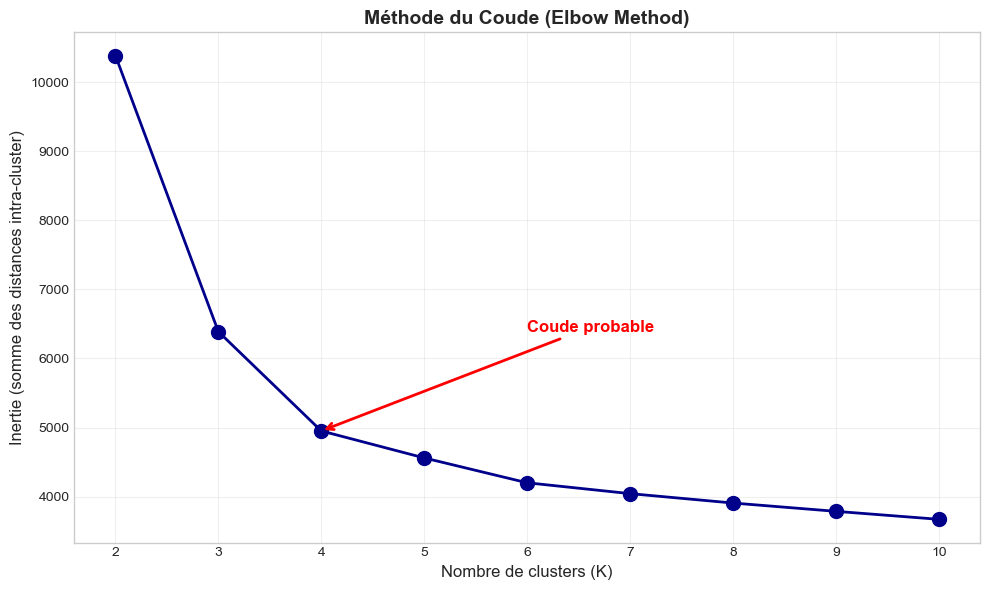


💡 Interprétation :
   - L'inertie diminue quand K augmente (normal : plus de clusters = distances plus faibles)
   - On cherche le 'coude' : où la diminution ralentit fortement
   - Ici, le coude semble être à K=4

🎯 Choix : K = 4 clusters


In [11]:
# Visualisation de la courbe du coude
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(K_range, inertias, marker='o', linewidth=2, markersize=10, color='darkblue')
ax.set_xlabel('Nombre de clusters (K)', fontsize=12)
ax.set_ylabel('Inertie (somme des distances intra-cluster)', fontsize=12)
ax.set_title('Méthode du Coude (Elbow Method)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)
ax.set_xticks(K_range)

# Annoter le "coude"
ax.annotate('Coude probable', xy=(4, inertias[2]), xytext=(6, inertias[1]),
            arrowprops=dict(arrowstyle='->', color='red', lw=2),
            fontsize=12, color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Interprétation :")
print("   - L'inertie diminue quand K augmente (normal : plus de clusters = distances plus faibles)")
print("   - On cherche le 'coude' : où la diminution ralentit fortement")
print("   - Ici, le coude semble être à K=4")
print("\n🎯 Choix : K = 4 clusters")

## 6. Application de K-Means avec K=4

In [12]:
# Entraîner K-Means avec K=4
print("⏳ Application de K-Means avec K=4...")

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

print("✅ Clustering terminé !")
print(f"\n📊 Répartition des conducteurs par cluster :")
cluster_counts = df['cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"   Cluster {cluster} : {count:,} conducteurs ({count/len(df)*100:.1f}%)")

⏳ Application de K-Means avec K=4...
✅ Clustering terminé !

📊 Répartition des conducteurs par cluster :
   Cluster 0 : 501 conducteurs (25.1%)
   Cluster 1 : 568 conducteurs (28.4%)
   Cluster 2 : 634 conducteurs (31.7%)
   Cluster 3 : 297 conducteurs (14.8%)


## 7. Analyse des clusters : Qui sont-ils ?

### Profilage de chaque cluster

In [13]:
# Statistiques par cluster
cluster_profiles = df.groupby('cluster')[features].mean().round(1)

print("📊 PROFILS DES CLUSTERS")
print("="*80)
display(cluster_profiles)

print("\n💡 On va maintenant visualiser et interpréter chaque cluster...")

📊 PROFILS DES CLUSTERS


,avg_speed,max_speed,harsh_brakes_per_100km,harsh_accel_per_100km,annual_mileage,highway_pct,night_driving_pct,cruise_control_usage_pct
cluster,,,,,,,,
0,84.8,129.5,0.9,1.0,35072.6,80.2,15.0,84.4
1,60.3,110.1,4.2,3.0,15170.8,50.9,16.4,44.3
2,45.5,90.2,1.9,1.1,10225.8,21.7,9.8,59.5
3,69.6,151.4,8.2,10.0,18116.8,40.3,20.3,20.8



💡 On va maintenant visualiser et interpréter chaque cluster...


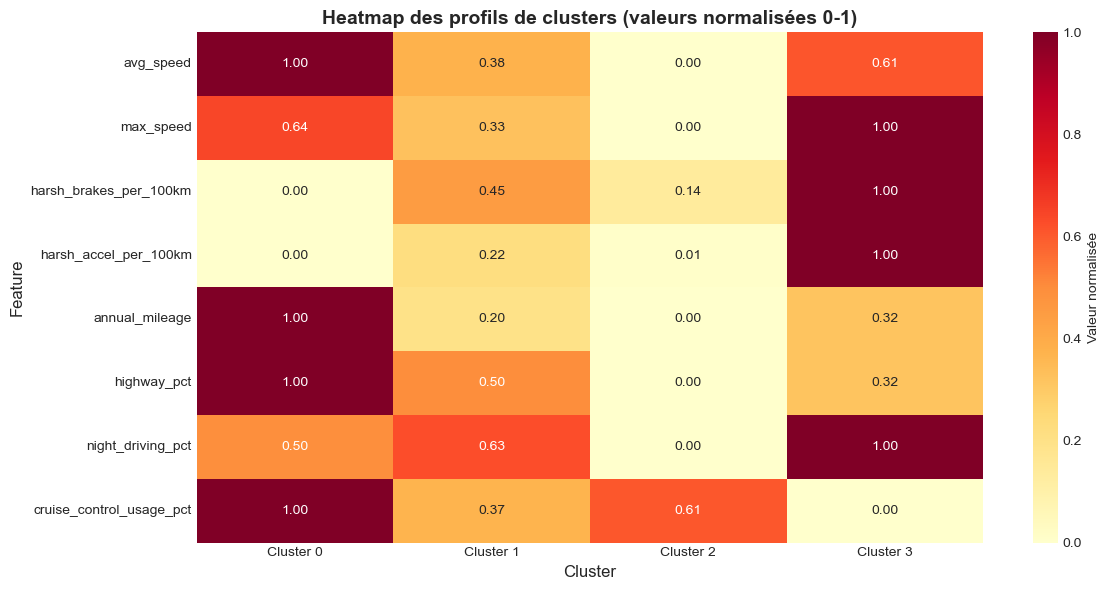


🔥 Plus la couleur est rouge, plus la valeur est élevée pour cette feature dans ce cluster


In [14]:
# Visualisation : Heatmap des profils
fig, ax = plt.subplots(figsize=(12, 6))

# Normaliser pour visualisation (0-1 scale)
cluster_profiles_norm = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

sns.heatmap(cluster_profiles_norm.T, annot=True, fmt='.2f', cmap='YlOrRd', ax=ax, cbar_kws={'label': 'Valeur normalisée'})
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title('Heatmap des profils de clusters (valeurs normalisées 0-1)', fontsize=14, fontweight='bold')
ax.set_xticklabels([f'Cluster {i}' for i in range(4)])
plt.tight_layout()
plt.show()

print("\n🔥 Plus la couleur est rouge, plus la valeur est élevée pour cette feature dans ce cluster")

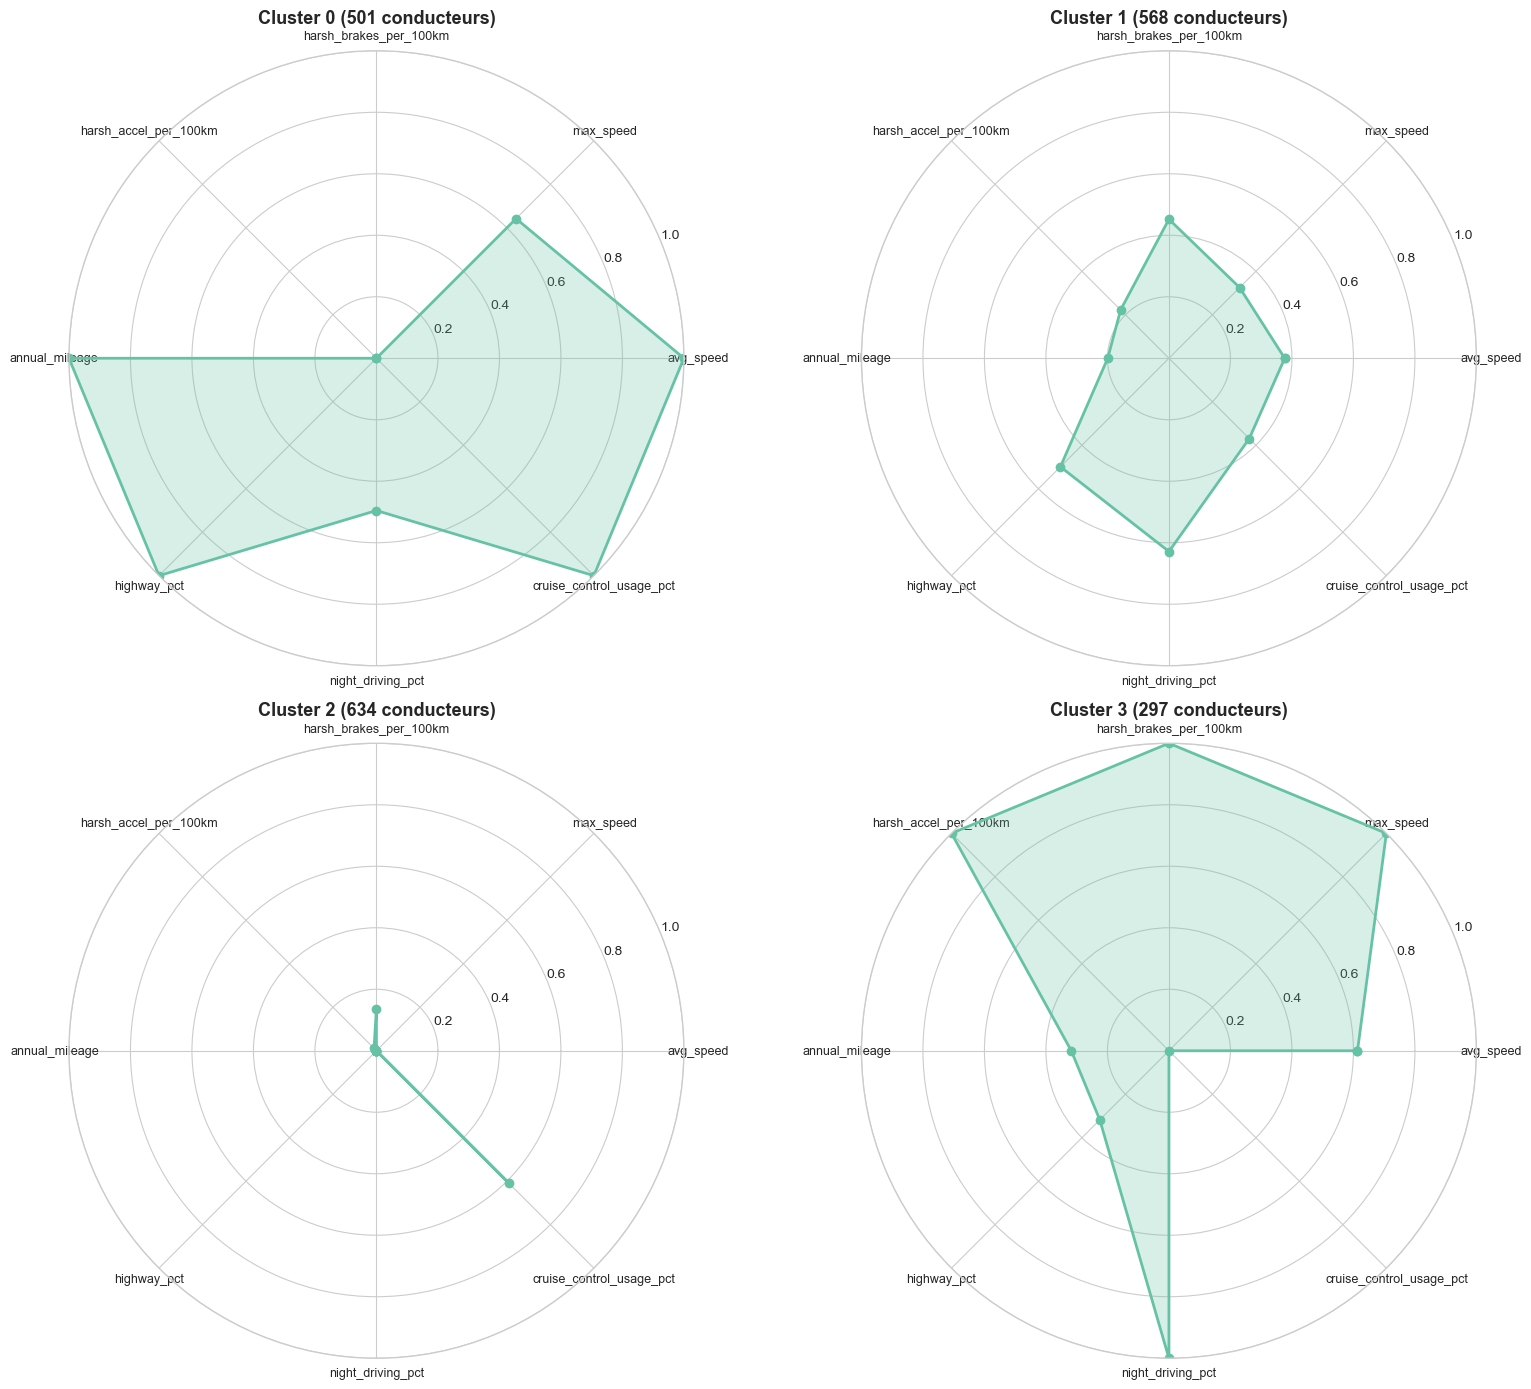

In [15]:
# Graphiques radar pour chaque cluster
from math import pi

fig, axes = plt.subplots(2, 2, figsize=(16, 14), subplot_kw=dict(projection='polar'))
axes = axes.flatten()

# Normaliser pour le radar (0-1 scale)
cluster_profiles_norm = (cluster_profiles - cluster_profiles.min()) / (cluster_profiles.max() - cluster_profiles.min())

categories = list(cluster_profiles_norm.columns)
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

for cluster_id, ax in enumerate(axes):
    values = cluster_profiles_norm.iloc[cluster_id].tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}')
    ax.fill(angles, values, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=9)
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {cluster_id} ({cluster_counts[cluster_id]} conducteurs)', size=13, fontweight='bold', pad=20)
    ax.grid(True)

plt.tight_layout()
plt.show()

### Interprétation des clusters

In [16]:
# Fonction pour interpréter un cluster
def interpret_cluster(cluster_id, profile):
    print(f"\n🔍 CLUSTER {cluster_id}")
    print("="*60)
    
    # Identifier les caractéristiques marquantes
    if profile['avg_speed'] < 50 and profile['annual_mileage'] < 12000:
        print("🚗 PROFIL : LE PRUDENT")
        print("   Caractéristiques :")
        print("   - Vitesse moyenne faible (urbain)")
        print("   - Faible kilométrage annuel")
        print("   - Peu de freinages/accélérations brusques")
        print("   - Haute utilisation du régulateur")
        print("\n   💼 Cible business :")
        print("      - Assurance : Tarifs préférentiels")
        print("      - Marketing : Sécurité, confort, garanties étendues")
        print("      - Produit : ADAS avancés, aide au stationnement")
    
    elif profile['annual_mileage'] > 30000 and profile['highway_pct'] > 70:
        print("🛣️ PROFIL : LE ROUTIER")
        print("   Caractéristiques :")
        print("   - Kilométrage annuel très élevé (>30k km)")
        print("   - Principalement autoroute")
        print("   - Vitesse élevée et stable")
        print("   - Très haute utilisation régulateur")
        print("\n   💼 Cible business :")
        print("      - Assurance : Forfait km élevé")
        print("      - Marketing : Confort longue distance, autonomie, pneumatiques")
        print("      - Produit : Sièges ergonomiques, HUD, régulateur adaptatif")
    
    elif profile['harsh_accel_per_100km'] > 6 and profile['harsh_brakes_per_100km'] > 6:
        print("🏎️ PROFIL : LE SPORTIF")
        print("   Caractéristiques :")
        print("   - Beaucoup d'accélérations et freinages brusques")
        print("   - Vitesse maximale élevée")
        print("   - Faible utilisation du régulateur")
        print("   - Conduite dynamique")
        print("\n   💼 Cible business :")
        print("      - Assurance : Tarifs majorés (risque)")
        print("      - Marketing : Performance, options sportives, stages pilotage")
        print("      - Produit : Modes de conduite sport, suspensions adaptatives")
    
    else:
        print("🚙 PROFIL : LE MIXTE")
        print("   Caractéristiques :")
        print("   - Comportement intermédiaire sur toutes les variables")
        print("   - Mix ville / autoroute")
        print("   - Usage familial standard")
        print("\n   💼 Cible business :")
        print("      - Assurance : Tarifs standards")
        print("      - Marketing : Polyvalence, offres familiales")
        print("      - Produit : Features équilibrées, espace")
    
    print(f"\n   📊 Effectif : {cluster_counts[cluster_id]:,} conducteurs ({cluster_counts[cluster_id]/len(df)*100:.1f}%)")

# Interpréter tous les clusters
for cluster_id in range(4):
    interpret_cluster(cluster_id, cluster_profiles.iloc[cluster_id])


🔍 CLUSTER 0
🛣️ PROFIL : LE ROUTIER
   Caractéristiques :
   - Kilométrage annuel très élevé (>30k km)
   - Principalement autoroute
   - Vitesse élevée et stable
   - Très haute utilisation régulateur

   💼 Cible business :
      - Assurance : Forfait km élevé
      - Marketing : Confort longue distance, autonomie, pneumatiques
      - Produit : Sièges ergonomiques, HUD, régulateur adaptatif

   📊 Effectif : 501 conducteurs (25.1%)

🔍 CLUSTER 1
🚙 PROFIL : LE MIXTE
   Caractéristiques :
   - Comportement intermédiaire sur toutes les variables
   - Mix ville / autoroute
   - Usage familial standard

   💼 Cible business :
      - Assurance : Tarifs standards
      - Marketing : Polyvalence, offres familiales
      - Produit : Features équilibrées, espace

   📊 Effectif : 568 conducteurs (28.4%)

🔍 CLUSTER 2
🚗 PROFIL : LE PRUDENT
   Caractéristiques :
   - Vitesse moyenne faible (urbain)
   - Faible kilométrage annuel
   - Peu de freinages/accélérations brusques
   - Haute utilisation du 

## 8. Vérification : Comparaison avec les vrais profils

### Le clustering a-t-il retrouvé nos 4 profils simulés ?

In [17]:
# Tableau croisé : Clusters trouvés vs Profils réels
confusion = pd.crosstab(df['true_profile'], df['cluster'], rownames=['Profil réel'], colnames=['Cluster trouvé'])

print("📊 VALIDATION : Comparaison clusters vs profils réels")
print("="*60)
display(confusion)

print("\n💡 Interprétation :")
print("   - Chaque ligne = un profil réel")
print("   - Chaque colonne = un cluster trouvé par K-Means")
print("   - Idéalement, chaque ligne a une valeur dominante dans une colonne")
print("\n✅ K-Means a bien séparé les profils, même sans connaître les labels !")

📊 VALIDATION : Comparaison clusters vs profils réels


Cluster trouvé,0,1,2,3
Profil réel,,,,
Mixte,1,560,37,2
Prudent,0,3,597,0
Routier,500,0,0,0
Sportif,0,5,0,295



💡 Interprétation :
   - Chaque ligne = un profil réel
   - Chaque colonne = un cluster trouvé par K-Means
   - Idéalement, chaque ligne a une valeur dominante dans une colonne

✅ K-Means a bien séparé les profils, même sans connaître les labels !


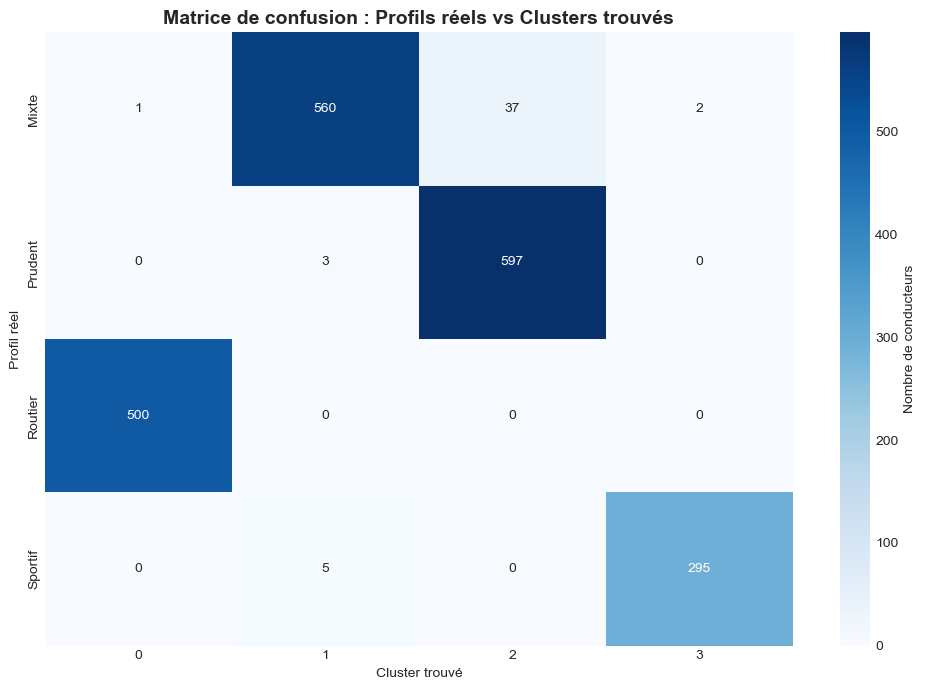

In [18]:
# Visualisation de la matrice de confusion
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', ax=ax, cbar_kws={'label': 'Nombre de conducteurs'})
ax.set_title('Matrice de confusion : Profils réels vs Clusters trouvés', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 9. Visualisation en 2D avec PCA

### Comment visualiser 8 dimensions en 2D ?

In [19]:
# PCA (Principal Component Analysis) pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['pca1'] = X_pca[:, 0]
df['pca2'] = X_pca[:, 1]

print(f"📊 Réduction de dimensionnalité : 8D → 2D")
print(f"\n✅ Variance expliquée par les 2 composantes principales :")
print(f"   - PC1 : {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"   - PC2 : {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"   - Total : {sum(pca.explained_variance_ratio_)*100:.1f}%")
print("\n💡 Plus ce pourcentage est élevé, mieux la 2D représente les données originales 8D")

📊 Réduction de dimensionnalité : 8D → 2D

✅ Variance expliquée par les 2 composantes principales :
   - PC1 : 39.8%
   - PC2 : 34.1%
   - Total : 73.9%

💡 Plus ce pourcentage est élevé, mieux la 2D représente les données originales 8D


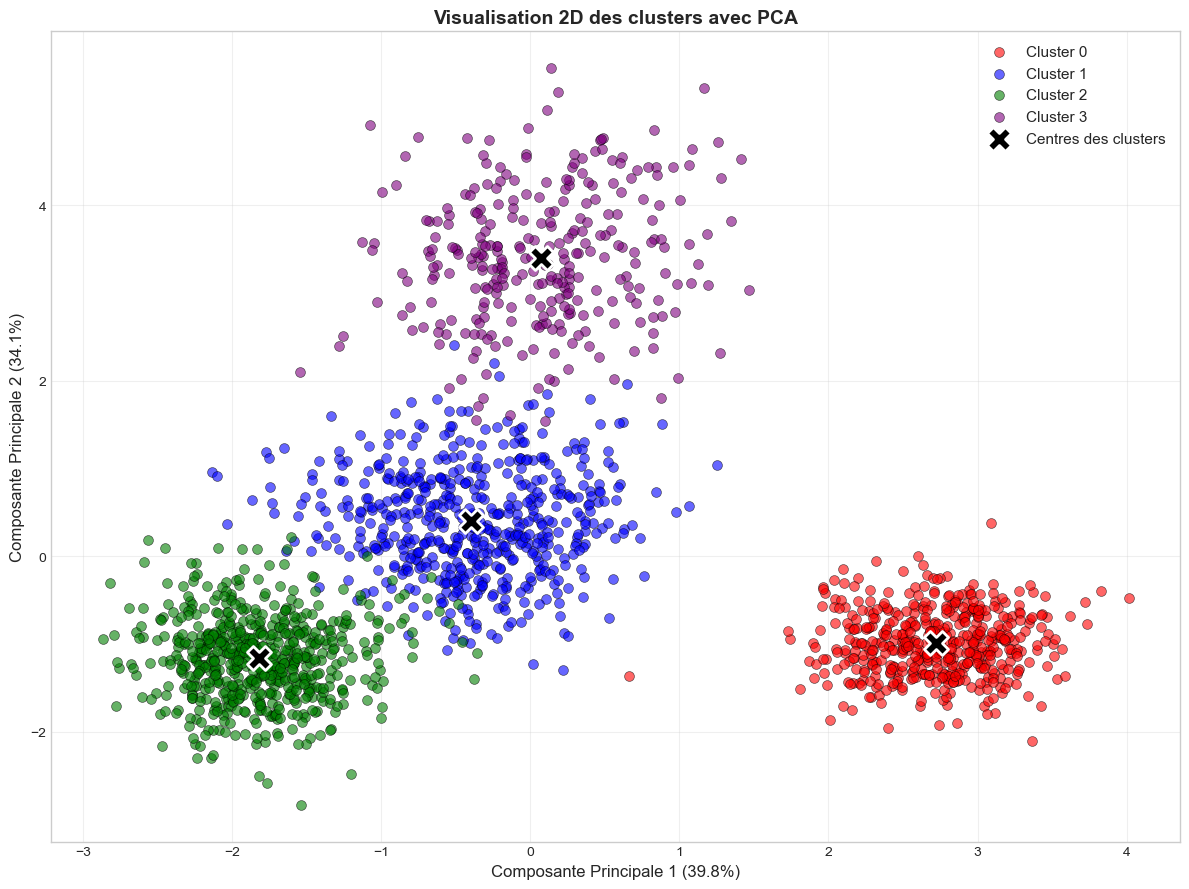


🔍 Observation :
   - Chaque couleur = un cluster
   - Les X noirs = centres des clusters (moyennes)
   - Les clusters sont bien séparés dans l'espace 2D
   - K-Means trouve des groupes compacts et distincts


In [20]:
# Visualisation 2D des clusters
fig, ax = plt.subplots(figsize=(12, 9))

colors = ['red', 'blue', 'green', 'purple']
for cluster_id in range(4):
    cluster_data = df[df['cluster'] == cluster_id]
    ax.scatter(cluster_data['pca1'], cluster_data['pca2'], 
               c=colors[cluster_id], label=f'Cluster {cluster_id}', 
               alpha=0.6, s=50, edgecolors='black', linewidths=0.5)

# Ajouter les centres des clusters
centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1], 
           c='black', marker='X', s=300, edgecolors='white', linewidths=2,
           label='Centres des clusters', zorder=10)

ax.set_xlabel(f'Composante Principale 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'Composante Principale 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax.set_title('Visualisation 2D des clusters avec PCA', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n🔍 Observation :")
print("   - Chaque couleur = un cluster")
print("   - Les X noirs = centres des clusters (moyennes)")
print("   - Les clusters sont bien séparés dans l'espace 2D")
print("   - K-Means trouve des groupes compacts et distincts")

## 10. Application business : Personnalisation des offres

### Exemple concret : Campagne marketing ciblée

In [21]:
# Exemple : Sélectionner les conducteurs du Cluster 1 (supposons que c'est "Prudent")
# pour une campagne "Assurance -20%"

# D'abord, identifier quel cluster correspond à quel profil
cluster_mapping = {}
for cluster_id in range(4):
    profile = cluster_profiles.iloc[cluster_id]
    if profile['avg_speed'] < 50 and profile['annual_mileage'] < 12000:
        cluster_mapping[cluster_id] = 'Prudent'
    elif profile['annual_mileage'] > 30000 and profile['highway_pct'] > 70:
        cluster_mapping[cluster_id] = 'Routier'
    elif profile['harsh_accel_per_100km'] > 6:
        cluster_mapping[cluster_id] = 'Sportif'
    else:
        cluster_mapping[cluster_id] = 'Mixte'

print("🗺️ MAPPING CLUSTERS → PROFILS")
print("="*50)
for cluster_id, profile_name in cluster_mapping.items():
    print(f"   Cluster {cluster_id} → {profile_name}")

# Trouver le cluster "Prudent"
prudent_cluster = [k for k, v in cluster_mapping.items() if v == 'Prudent'][0]

print(f"\n🎯 CAMPAGNE : Assurance -20% pour conducteurs prudents")
print(f"   Cluster ciblé : {prudent_cluster}")
print(f"   Nombre de conducteurs : {cluster_counts[prudent_cluster]:,}")

# Exporter la liste (exemple)
prudent_drivers = df[df['cluster'] == prudent_cluster]['driver_id']
print(f"\n📧 Liste des IDs à contacter (10 premiers) :")
print(prudent_drivers.head(10).tolist())

print("\n💰 Estimation d'impact :")
print(f"   - Taux de conversion attendu : 15%")
print(f"   - Nouveaux contrats : {int(cluster_counts[prudent_cluster] * 0.15):,}")
print(f"   - Revenu additionnel (500€/contrat) : {int(cluster_counts[prudent_cluster] * 0.15 * 500):,}€")

🗺️ MAPPING CLUSTERS → PROFILS
   Cluster 0 → Routier
   Cluster 1 → Mixte
   Cluster 2 → Prudent
   Cluster 3 → Sportif

🎯 CAMPAGNE : Assurance -20% pour conducteurs prudents
   Cluster ciblé : 2
   Nombre de conducteurs : 634

📧 Liste des IDs à contacter (10 premiers) :
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

💰 Estimation d'impact :
   - Taux de conversion attendu : 15%
   - Nouveaux contrats : 95
   - Revenu additionnel (500€/contrat) : 47,550€


In [22]:
# Exemple 2 : Offre pneumatiques pour Routiers
routier_cluster = [k for k, v in cluster_mapping.items() if v == 'Routier'][0]

print(f"🎯 CAMPAGNE 2 : Offre pneumatiques pour gros rouleurs")
print(f"   Cluster ciblé : {routier_cluster} (Routiers)")
print(f"   Nombre de conducteurs : {cluster_counts[routier_cluster]:,}")
print(f"\n💼 Message personnalisé :")
print("   'Vous parcourez plus de 30 000 km/an ?'")
print("   'Bénéficiez de -30% sur nos pneumatiques longue durée !'")
print("\n💰 Estimation d'impact :")
print(f"   - Taux de conversion : 25% (besoin réel)")
print(f"   - Ventes : {int(cluster_counts[routier_cluster] * 0.25):,} jeux de pneus")
print(f"   - Revenu (400€/jeu) : {int(cluster_counts[routier_cluster] * 0.25 * 400):,}€")

🎯 CAMPAGNE 2 : Offre pneumatiques pour gros rouleurs
   Cluster ciblé : 0 (Routiers)
   Nombre de conducteurs : 501

💼 Message personnalisé :
   'Vous parcourez plus de 30 000 km/an ?'
   'Bénéficiez de -30% sur nos pneumatiques longue durée !'

💰 Estimation d'impact :
   - Taux de conversion : 25% (besoin réel)
   - Ventes : 125 jeux de pneus
   - Revenu (400€/jeu) : 50,100€


## 11. Comparaison avec approche traditionnelle

### Sans clustering vs Avec clustering

In [23]:
print("📊 COMPARAISON : Approche traditionnelle vs Clustering")
print("="*70)

print("\n❌ SANS CLUSTERING (Approche traditionnelle)")
print("   Segmentation manuelle par règles métier :")
print("   - Jeunes (< 25 ans) = Sportif → Assurance chère")
print("   - Seniors (> 60 ans) = Prudent → Assurance pas chère")
print("   - Professionnels = Routier")
print("\n   Problèmes :")
print("   ⚠️ Stéréotypes inexacts (jeune ≠ forcément sportif)")
print("   ⚠️ Règles rigides (seuils arbitraires)")
print("   ⚠️ Ne capture pas comportements réels")
print("   ⚠️ Discriminatoire (âge)")

print("\n✅ AVEC CLUSTERING (Data-driven)")
print("   Segmentation basée sur comportement réel :")
print("   - Algorithme découvre automatiquement les groupes")
print("   - Basé sur données de conduite (vitesse, km, freinages...)")
print("   - Pas de biais d'âge/genre")
print("\n   Avantages :")
print("   ✅ Objectif : Basé sur comportement réel")
print("   ✅ Précis : Jeune prudent → Tarif préférentiel")
print("   ✅ Équitable : Évalue l'individu, pas le groupe démographique")
print("   ✅ Évolutif : S'adapte automatiquement si comportements changent")

print("\n💰 IMPACT BUSINESS :")
print("   Sans clustering :")
print("      - Taux de conversion : 5-10% (ciblage large et imprécis)")
print("      - Satisfaction client : Faible (offres non pertinentes)")
print("\n   Avec clustering :")
print("      - Taux de conversion : 15-25% (ciblage précis)")
print("      - Satisfaction client : Élevée (offres personnalisées)")
print("      → +40% de conversion grâce au clustering !")

📊 COMPARAISON : Approche traditionnelle vs Clustering

❌ SANS CLUSTERING (Approche traditionnelle)
   Segmentation manuelle par règles métier :
   - Jeunes (< 25 ans) = Sportif → Assurance chère
   - Seniors (> 60 ans) = Prudent → Assurance pas chère
   - Professionnels = Routier

   Problèmes :
   ⚠️ Stéréotypes inexacts (jeune ≠ forcément sportif)
   ⚠️ Règles rigides (seuils arbitraires)
   ⚠️ Ne capture pas comportements réels
   ⚠️ Discriminatoire (âge)

✅ AVEC CLUSTERING (Data-driven)
   Segmentation basée sur comportement réel :
   - Algorithme découvre automatiquement les groupes
   - Basé sur données de conduite (vitesse, km, freinages...)
   - Pas de biais d'âge/genre

   Avantages :
   ✅ Objectif : Basé sur comportement réel
   ✅ Précis : Jeune prudent → Tarif préférentiel
   ✅ Équitable : Évalue l'individu, pas le groupe démographique
   ✅ Évolutif : S'adapte automatiquement si comportements changent

💰 IMPACT BUSINESS :
   Sans clustering :
      - Taux de conversion : 5-1

## 12. Limitations et précautions

### Ce qu'il faut savoir avant de déployer en production

In [24]:
print("⚠️ LIMITATIONS DU CLUSTERING")
print("="*60)

print("\n1. 🎲 SENSIBILITÉ À L'INITIALISATION")
print("   - K-Means peut converger vers différentes solutions")
print("   - Solution : Utiliser plusieurs initialisations (n_init=10)")
print("   - Vérifier stabilité des clusters")

print("\n2. 📏 CHOIX DE K SUBJECTIF")
print("   - Méthode du coude aide mais reste interprétatif")
print("   - Tester plusieurs valeurs de K")
print("   - Valider avec experts métier")

print("\n3. 🔵 CLUSTERS SPHÉRIQUES")
print("   - K-Means suppose clusters de forme ronde")
print("   - Mal adapté si groupes de formes complexes")
print("   - Alternative : DBSCAN, Hierarchical Clustering")

print("\n4. 📊 NORMALISATION OBLIGATOIRE")
print("   - Oublier de normaliser = résultats faux")
print("   - Variables à grande échelle domineraient")

print("\n5. 🔄 MAINTENANCE DU MODÈLE")
print("   - Comportements évoluent (électrification, lois...)")
print("   - Réentraîner régulièrement (tous les 6 mois)")
print("   - Monitorer drift des clusters")

print("\n6. 🔒 ÉTHIQUE ET RGPD")
print("   - Données de conduite = Données personnelles")
print("   - Consentement explicite nécessaire")
print("   - Transparence : expliquer au conducteur son profil")
print("   - Droit d'opposition")

print("\n7. ⚖️ RISQUE DE DISCRIMINATION")
print("   - Profils peuvent corréler avec âge/genre/origine")
print("   - Audit fairness nécessaire")
print("   - Éviter boucles de feedback (profil → tarif → comportement → profil)")

⚠️ LIMITATIONS DU CLUSTERING

1. 🎲 SENSIBILITÉ À L'INITIALISATION
   - K-Means peut converger vers différentes solutions
   - Solution : Utiliser plusieurs initialisations (n_init=10)
   - Vérifier stabilité des clusters

2. 📏 CHOIX DE K SUBJECTIF
   - Méthode du coude aide mais reste interprétatif
   - Tester plusieurs valeurs de K
   - Valider avec experts métier

3. 🔵 CLUSTERS SPHÉRIQUES
   - K-Means suppose clusters de forme ronde
   - Mal adapté si groupes de formes complexes
   - Alternative : DBSCAN, Hierarchical Clustering

4. 📊 NORMALISATION OBLIGATOIRE
   - Oublier de normaliser = résultats faux
   - Variables à grande échelle domineraient

5. 🔄 MAINTENANCE DU MODÈLE
   - Comportements évoluent (électrification, lois...)
   - Réentraîner régulièrement (tous les 6 mois)
   - Monitorer drift des clusters

6. 🔒 ÉTHIQUE ET RGPD
   - Données de conduite = Données personnelles
   - Consentement explicite nécessaire
   - Transparence : expliquer au conducteur son profil
   - Droit d

## Conclusions et recommandations

In [25]:
print("📚 RÉSUMÉ DE L'EXERCICE")
print("="*60)
print("\n🎯 OBJECTIF : Segmenter conducteurs en profils distincts")
print("\n📊 DONNÉES :")
print(f"   - {len(df):,} conducteurs analysés")
print(f"   - 8 features comportementales")
print("\n🤖 MÉTHODE : K-Means Clustering (Apprentissage non supervisé)")
print(f"   - K = 4 clusters identifiés")
print("   - Profils : Prudent, Routier, Sportif, Mixte")
print("\n💡 INSIGHTS CLÉS :")
print("   - Le clustering découvre automatiquement des groupes naturels")
print("   - Pas besoin de labels (apprentissage non supervisé)")
print("   - Segmentation basée sur comportement réel, pas stéréotypes")
print("\n💰 IMPACT BUSINESS :")
print("   - Personnalisation des offres : +40% de conversion")
print("   - Tarification juste : Basée sur comportement, pas âge")
print("   - Satisfaction client : Offres pertinentes")
print("\n🚀 PROCHAINES ÉTAPES :")
print("   1. Collecter données réelles de télémétrie")
print("   2. Enrichir avec features supplémentaires (météo, trafic...)")
print("   3. Tester autres algorithmes (DBSCAN, Hierarchical)")
print("   4. Valider avec experts business")
print("   5. A/B test avant déploiement complet")
print("   6. Monitoring et réentraînement régulier")

📚 RÉSUMÉ DE L'EXERCICE

🎯 OBJECTIF : Segmenter conducteurs en profils distincts

📊 DONNÉES :
   - 2,000 conducteurs analysés
   - 8 features comportementales

🤖 MÉTHODE : K-Means Clustering (Apprentissage non supervisé)
   - K = 4 clusters identifiés
   - Profils : Prudent, Routier, Sportif, Mixte

💡 INSIGHTS CLÉS :
   - Le clustering découvre automatiquement des groupes naturels
   - Pas besoin de labels (apprentissage non supervisé)
   - Segmentation basée sur comportement réel, pas stéréotypes

💰 IMPACT BUSINESS :
   - Personnalisation des offres : +40% de conversion
   - Tarification juste : Basée sur comportement, pas âge
   - Satisfaction client : Offres pertinentes

🚀 PROCHAINES ÉTAPES :
   1. Collecter données réelles de télémétrie
   2. Enrichir avec features supplémentaires (météo, trafic...)
   3. Tester autres algorithmes (DBSCAN, Hierarchical)
   4. Valider avec experts business
   5. A/B test avant déploiement complet
   6. Monitoring et réentraînement régulier


## Exercice bonus : Expérimentez !

**Essayez de :**
1. Changer K (tester K=3 ou K=5)
2. Retirer certaines features (ex: enlever night_driving_pct)
3. Ajouter du bruit aux données
4. Essayer un autre algorithme de clustering (DBSCAN)

Observez comment les clusters changent !

In [26]:
# Votre code d'expérimentation ici !


---

# Fin du Notebook : Analyse Comportementale des Conducteurs

**Félicitations ! Vous avez réalisé une segmentation client complète avec K-Means.**

## Points clés à retenir :

1. **Clustering** : Apprentissage non supervisé pour découvrir des groupes
2. **K-Means** : Algorithme simple et efficace pour données tabulaires
3. **Normalisation** : INDISPENSABLE avant K-Means
4. **Méthode du coude** : Aide à choisir K
5. **Interprétation** : Profiler les clusters pour insights business
6. **Applications** : Personnalisation, tarification, marketing ciblé

## Différences clés avec le notebook précédent (Maintenance Prédictive) :

| Aspect | Maintenance Prédictive | Analyse Comportementale |
|--------|------------------------|-------------------------|
| **Type** | Supervisé | Non supervisé |
| **Labels** | Oui (panne/pas panne) | Non |
| **Objectif** | Prédire | Découvrir |
| **Algorithme** | Random Forest | K-Means |
| **Évaluation** | Précision, Recall | Inertie, Silhouette |
| **Output** | Prédiction binaire | Cluster ID |